
### The Data

| Column     | Description              |
|------------|--------------------------|
|`processId`|The unique identifier for the process that generated the event - int64 |
|`threadId`|ID for the thread spawning the log - int64|
|`parentProcessId`|Label for the process spawning this log - int64|
|`userId`|ID of user spawning the log|Numerical - int64|
|`mountNamespace`|Mounting restrictions the process log works within - int64|
|`argsNum`|Number of arguments passed to the event - int64|
|`returnValue`|Value returned from the event log (usually 0) - int64|
|`sus_label`|Binary label as suspicous event (1 is suspicious, 0 is not) - int64|

More information on the dataset: [BETH dataset](accreditation.md)

Paper explaining the dataset in detail:
[BETH Dataset: Real Cybersecurity Data for Anomaly Detection Research](https://www.gatsby.ucl.ac.uk/~balaji/udl2021/accepted-papers/UDL2021-paper-033.pdf)

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from supports import *
import time
from time import strftime, localtime

# # pytorch random seed
# torch.manual_seed(0)
# # python random seed
# random.seed(0)
# # numpy random seed
# np.random.seed(0)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
# from sklearn.metrics import accuracy_score  # uncomment to use sklearn

In [2]:
# Get label balane as anomaly datasets have few positive samples
df = pd.read_csv('data/labelled_train.csv')
vc = df.iloc[:,-1].value_counts()
pos_weight_tensor = torch.tensor((vc.max()/vc.min()).round()).float()
print(pos_weight_tensor)

tensor(600.)


In [3]:
# Number of features after preprocessing
num_features = 9
# Number of labels
num_labels = 2
# Define batch size
batch_size = 128

# Import training data
dataset_train = CyberDataset('data/labelled_train.csv', num_labels)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) #, num_workers=10)
# Import validation data
dataset_validation = CyberDataset('data/labelled_validation.csv', num_labels)
dataloader_validation = DataLoader(dataset_validation, batch_size=batch_size, shuffle=True) #, num_workers=10)
# Import test data
dataset_test = CyberDataset('data/labelled_test.csv', num_labels)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True) #, num_workers=4)

# Define model
dim_in, dim_out = 9, 1
model = CyberNN(dim_in, dim_out)

# Set up device
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model.to(device)
print(f"Model is on: {next(model.parameters()).device}")

# Define loss function, optimizer and accuracy metric
criterion =  nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor.to(device))
optimizer = optim.SGD(model.parameters(), lr=0.001)
accuracy_metric = Accuracy('binary').to(device)

losses_train = []
losses_validation = []
accuracies_validation = []

n_epochs = 10
for i in range(n_epochs):
    print(f"Epoch [ {i+1}/{n_epochs} ]", '-'*50)
    # Train
    loss = train_epoch(model, dataloader_train, criterion, optimizer, device)
    losses_train.append(loss)
    print(f'** Training Loss: {loss:.4f}')
    # Validate
    loss, accuracy = validate_epoch(model, dataloader_validation, criterion, device, accuracy_metric)
    print(f'** Validation Loss: {loss:.4f}')
    losses_validation.append(loss)
    print(f'** Validation Accuracy: {accuracy :.4f}')
    accuracies_validation.append(accuracy)



Model is on: mps:0
Epoch [ 1/10 ] --------------------------------------------------
** Training Loss: 0.8528
** Validation Loss: 0.4756
** Validation Accuracy: 0.9958
Epoch [ 2/10 ] --------------------------------------------------
** Training Loss: 0.7269
** Validation Loss: 0.4580
** Validation Accuracy: 0.9958
Epoch [ 3/10 ] --------------------------------------------------
** Training Loss: 0.6778
** Validation Loss: 0.4681
** Validation Accuracy: 0.9958
Epoch [ 4/10 ] --------------------------------------------------
** Training Loss: 0.6437
** Validation Loss: 0.2934
** Validation Accuracy: 0.9958
Epoch [ 5/10 ] --------------------------------------------------
** Training Loss: 0.6201
** Validation Loss: 0.2357
** Validation Accuracy: 0.9958
Epoch [ 6/10 ] --------------------------------------------------
** Training Loss: 0.5918
** Validation Loss: 0.2475
** Validation Accuracy: 0.9958
Epoch [ 7/10 ] --------------------------------------------------
** Training Loss: 0.5

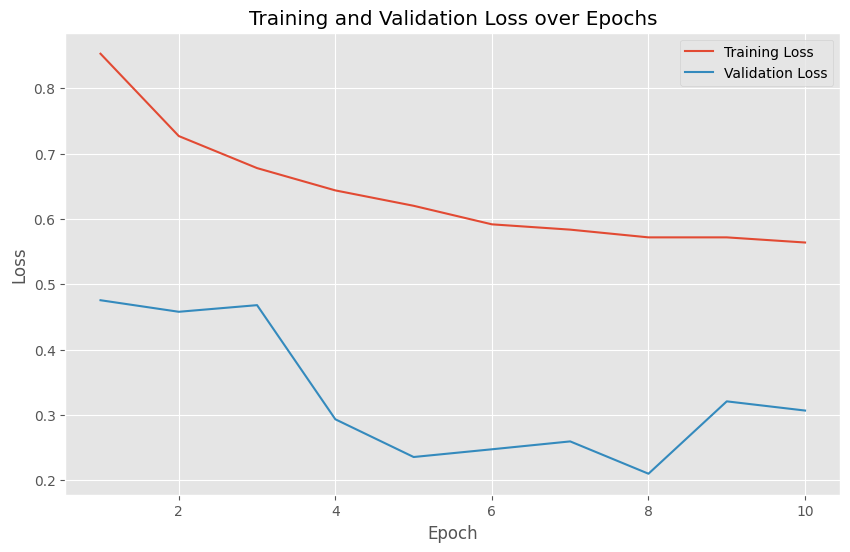

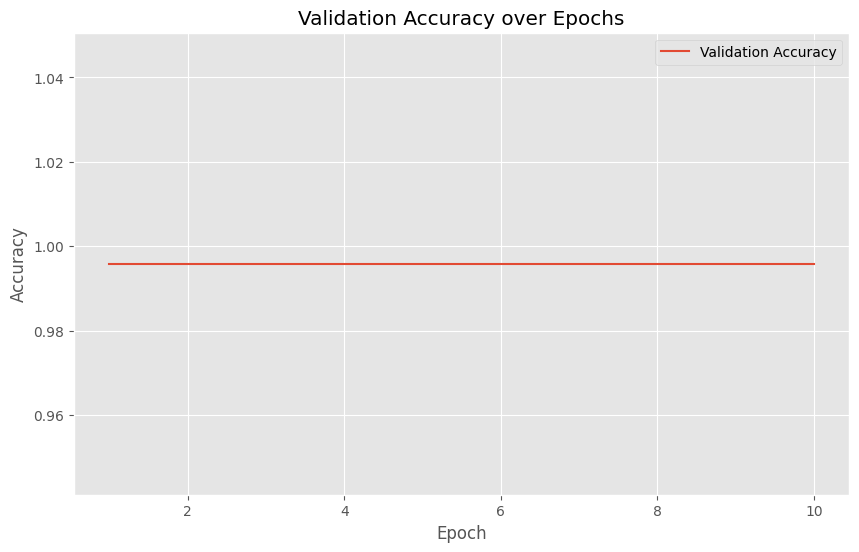

In [4]:
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), losses_train, label='Training Loss')
plt.plot(range(1, n_epochs + 1), losses_validation, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Plot the validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), accuracies_validation, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()

In [9]:
# Test the model with test data
loss, accuracy = test_model(model, dataloader_test, criterion, device, accuracy_metric)
print(f'** Test Loss: {loss:.4f}')
print(f'** Test Accuracy: {accuracy:.4f}')

** Test Loss: 523.0745
** Test Accuracy: 0.0927


#### Conclusion
Due to the nature of anomaly detaction tasks having few positive samples, weight adujustment for label imbalance has been implemented to the loss function for a better optimization. Test accuracy is only 0.09, despite the validation accuaracy being very high at 0.9. It is possible that the spliting of train, validation and test datasets is not properly done and so the train and validation datasets are not a good representation of the test dataset. Other techniques for mitigating label imbalance as well as more appropriate models for anormaly detection could be explored for this taks.  